# 1.使用朴素贝叶斯解决20类新闻分类


In [2]:
# 导入所需的库
from sklearn.datasets import fetch_20newsgroups

# 加载20newsgroups数据集
newsgroups = fetch_20newsgroups(subset='all', 
                               remove=('headers', 'footers', 'quotes'))

# 查看数据基本信息
print("数据集大小:", len(newsgroups.data))
print("目标类别数:", len(newsgroups.target_names))
print("\n类别名称:", newsgroups.target_names)



数据集大小: 18846
目标类别数: 20

类别名称: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [4]:
# 将数据集分为训练集和测试集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    newsgroups.data, 
    newsgroups.target,
    test_size=0.2,  # 测试集占20%，训练集占80%
    random_state=42  # 设置随机种子，确保结果可复现
)

# 打印训练集和测试集的大小
print("训练集大小:", len(X_train))
print("测试集大小:", len(X_test))


训练集大小: 15076
测试集大小: 3770


In [9]:
# 使用TF-IDF向量化器将文本转换为特征向量
from sklearn.feature_extraction.text import TfidfVectorizer

# 创建TF-IDF向量化器
vectorizer = TfidfVectorizer(
    max_features=10000,  # 使用最常见的10000个词作为特征
    stop_words='english',  # 去除英文停用词
    max_df=0.5,  # 在超过50%的文档中出现的词会被去除
    min_df=2  # 出现次数少于2次的词会被去除
)

# 对训练集进行拟合和转换
X_train_tfidf = vectorizer.fit_transform(X_train)
# 检查宗教/政治相关类别的文本
religion_politics_categories = ['talk.religion.misc', 'talk.politics.guns', 
                              'talk.politics.mideast', 'talk.politics.misc', 'soc.religion.christian']

# 获取这些类别的索引
category_indices = [newsgroups.target_names.index(cat) for cat in religion_politics_categories]

# 找出属于这些类别的训练样本
mask = np.isin(y_train, category_indices)
religion_politics_texts = np.array(X_train)[mask]

# 定义一些常见的特殊字符和非标准表达
special_chars = ['$', '@', '#', '%', '&', '*', '!', '?', '/', '\\', 
                '|', '<', '>', '{', '}', '[', ']']
                
# 检查并打印包含大量特殊字符的样本数量
noisy_samples = 0
for text in religion_politics_texts:
    special_char_count = sum(text.count(char) for char in special_chars)
    if special_char_count > 50:  # 设置阈值为50个特殊字符
        noisy_samples += 1

print(f"\n在宗教和政治类别中:")
print(f"检查的样本总数: {len(religion_politics_texts)}")
print(f"包含大量特殊字符的样本数: {noisy_samples}")
print(f"噪声样本比例: {noisy_samples/len(religion_politics_texts)*100:.2f}%")

# 对测试集进行转换
X_test_tffid = vectorizer.transform(X_test)

# 打印特征维度
print("特征维度:", X_train_tfidf.shape[1])
print("训练集样本数:", X_train_tfidf.shape[0])
print("测试集样本数:", X_test_tfidf.shape[0])



在宗教和政治类别中:
检查的样本总数: 3383
包含大量特殊字符的样本数: 96
噪声样本比例: 2.84%
特征维度: 10000
训练集样本数: 15076
测试集样本数: 3770


In [10]:
# 使用朴素贝叶斯进行文本分类
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# 创建朴素贝叶斯分类器
nb_classifier = MultinomialNB()

# 在训练集上训练模型
nb_classifier.fit(X_train_tfidf, y_train)#y_train是标签

# 在测试集上进行预测
y_pred = nb_classifier.predict(X_test_tffid)#X_test_tffid是测试集的特征

# 打印分类报告
print("分类报告:")
print(classification_report(y_test, y_pred, target_names=newsgroups.target_names))


分类报告:
                          precision    recall  f1-score   support

             alt.atheism       0.68      0.43      0.53       151
           comp.graphics       0.65      0.67      0.66       202
 comp.os.ms-windows.misc       0.65      0.65      0.65       195
comp.sys.ibm.pc.hardware       0.54      0.74      0.63       183
   comp.sys.mac.hardware       0.81      0.65      0.72       205
          comp.windows.x       0.84      0.79      0.81       215
            misc.forsale       0.75      0.70      0.72       193
               rec.autos       0.77      0.69      0.73       196
         rec.motorcycles       0.45      0.79      0.58       168
      rec.sport.baseball       0.91      0.82      0.86       211
        rec.sport.hockey       0.91      0.89      0.90       198
               sci.crypt       0.76      0.79      0.78       201
         sci.electronics       0.77      0.61      0.68       202
                 sci.med       0.85      0.86      0.85       194
   

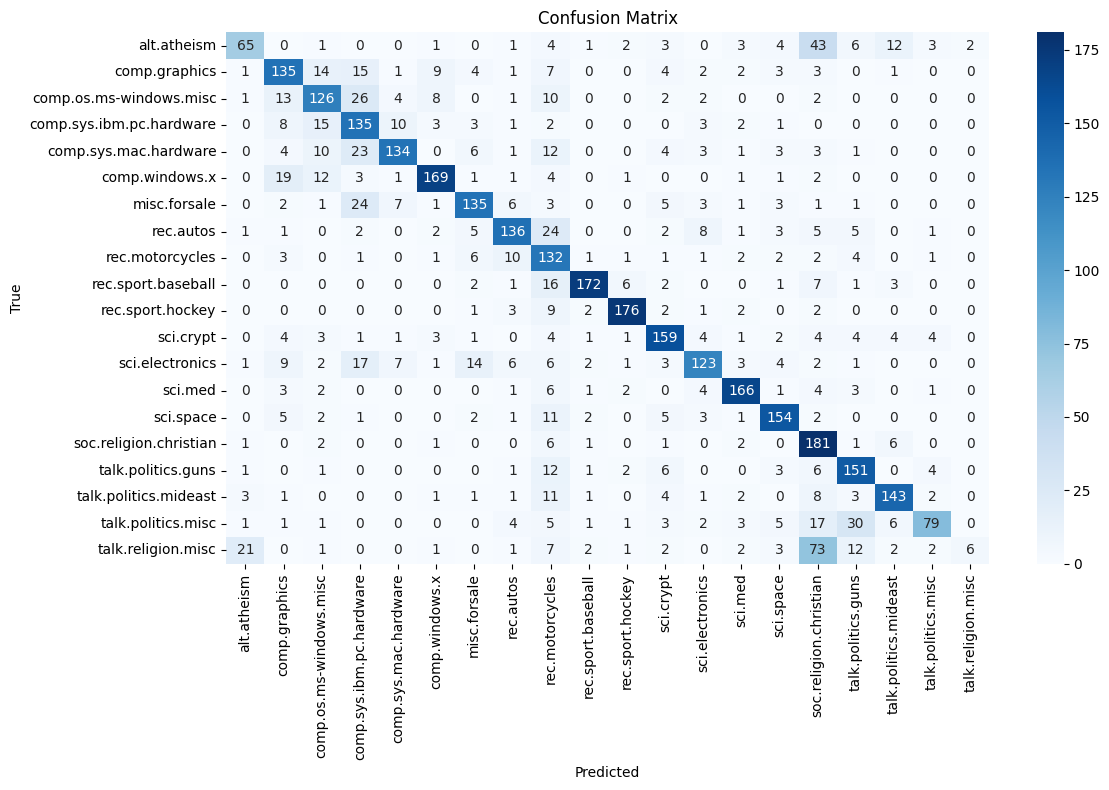

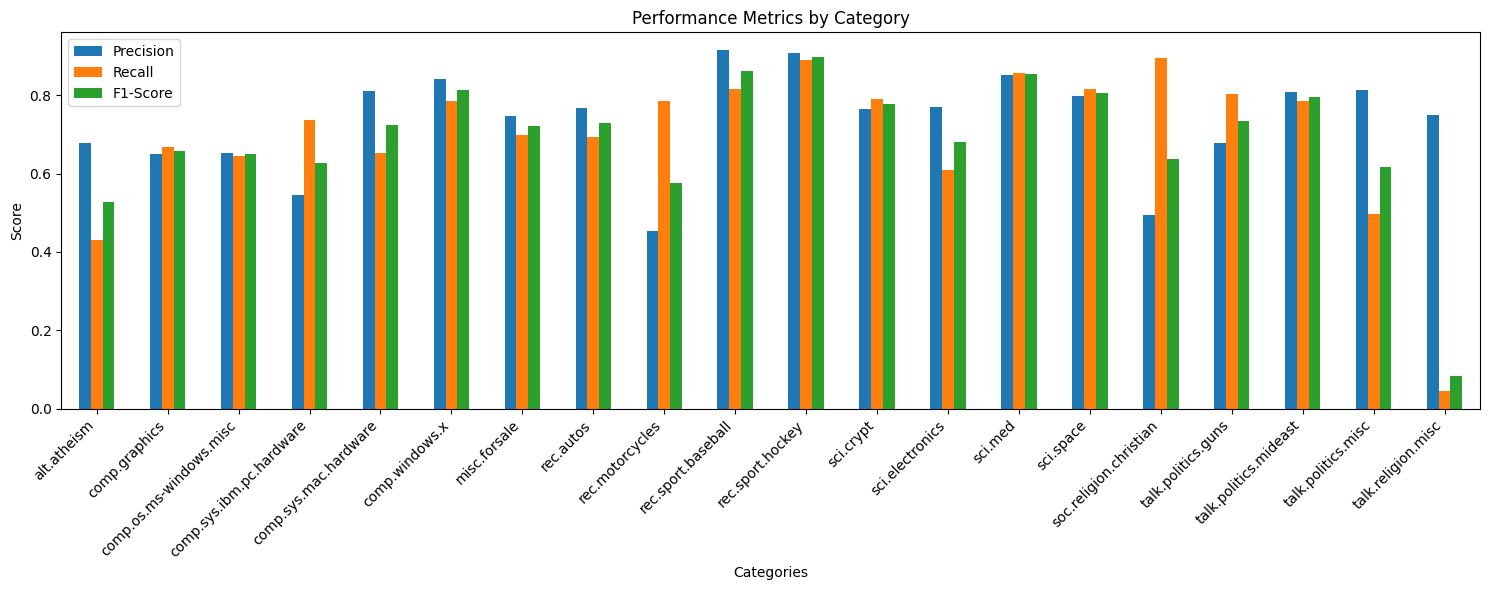

In [11]:
# 导入所需的库
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 创建一个图形和轴对象
plt.figure(figsize=(12, 8))

# 使用seaborn绘制热力图
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=newsgroups.target_names,
            yticklabels=newsgroups.target_names)

# 设置标题和标签
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# 调整布局以防止标签被切割
plt.tight_layout()

# 显示图形
plt.show()

# 计算每个类别的精确率、召回率和F1分数
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# 创建性能指标的条形图
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=newsgroups.target_names)

# 绘制条形图
metrics_df.plot(kind='bar', figsize=(15, 6))
plt.title('Performance Metrics by Category')
plt.xlabel('Categories')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
